In [2]:
import numpy as np
import cupy as cp
from cupy import cutensor
from time import perf_counter_ns
import matplotlib.pyplot as plt


def generateTestDataDim(p, q, numberOfCell, geometryDim=3, topologyDim=3):
    I = q * (q+1) * (q+2) / 6
    K = M = (p+1) * (p+2) * (p+3) / 6
    J = numberOfCell
    L = geometryDim
    return list(map(int, (I, J, K, L, M)))



In [5]:
def calc(*args):
	dtype = np.float32
	cp.get_default_memory_pool().free_all_blocks()

	I, J, K, L, M = generateTestDataDim(*args)
	# print("Data benchmark:[I,J,K,L,M]=[{},{},{},{},{}]\n".format(I, J, K, L, M))
	a = np.random.rand(I).astype(dtype)
	b = np.random.rand(I, J, K, L).astype(dtype)
	c = np.random.rand(I, J, M, L).astype(dtype)
	d = np.random.rand(J).astype(dtype)
	# time 

	a_gpu = cp.asarray(a)
	b_gpu = cp.asarray(b)
	c_gpu = cp.asarray(c)
	d_gpu = cp.asarray(d)
	warmup = 1
	cycle = 3

	# for plot
	time_data = []
	acc = []

	extent = {'i': I, 'j': J, 'k': K, 'm': M, 'l': L}
	mode_a = ('i')
	mode_b = ('i', 'j', 'k', 'l')
	mode_c = ('i', 'j', 'm', 'l')
	mode_d = ('j')
	mode_e = ('j', 'k', 'm')
	mode_f = ('i', 'j', 'k', 'l')
	mode_g = ('j', 'k', 'm')
	mode_a = cutensor.create_mode(*mode_a)
	mode_b = cutensor.create_mode(*mode_b)
	mode_c = cutensor.create_mode(*mode_c)
	mode_d = cutensor.create_mode(*mode_d)
	mode_e = cutensor.create_mode(*mode_e)
	mode_f = cutensor.create_mode(*mode_f)
	mode_g = cutensor.create_mode(*mode_g)

	t_avg = 0
	for i in range(cycle):
	    cp.cuda.Stream.null.synchronize()
	    t1_start = perf_counter_ns()
	    desc_a = cutensor.create_tensor_descriptor(a_gpu)
	    desc_b = cutensor.create_tensor_descriptor(b_gpu)
	    desc_c = cutensor.create_tensor_descriptor(c_gpu)
	    desc_d = cutensor.create_tensor_descriptor(d_gpu)
	    f_gpu = cp.empty((I, J, K, L)).astype(dtype)
	    e_gpu = cp.empty((J, K, M)).astype(dtype)
	    g_gpu = cp.empty((J, K, M)).astype(dtype)
	    desc_g = cutensor.create_tensor_descriptor(g_gpu)
	    desc_f = cutensor.create_tensor_descriptor(f_gpu)
	    desc_e = cutensor.create_tensor_descriptor(e_gpu)
	    f_gpu = cutensor.contraction(1.0,
	                                 a_gpu, desc_a, mode_a,
	                                 b_gpu, desc_b, mode_b,
	                                 0.0,
	                                 f_gpu, desc_f, mode_f)
	    g_gpu = cutensor.contraction(1.0,
	                                 f_gpu, desc_f, mode_f,
	                                 c_gpu, desc_c, mode_c,
	                                 0.0,
	                                 g_gpu, desc_g, mode_g)
	    e_gpu = cutensor.contraction(1.0,
	                                 g_gpu, desc_g, mode_g,
	                                 d_gpu, desc_d, mode_d,
	                                 0.0,
	                                 e_gpu, desc_e, mode_e)
	    cp.cuda.Stream.null.synchronize()
	    t1_stop = perf_counter_ns()
	    t1 = (t1_stop-t1_start) / 1e6
		# time
	    e2 = e_gpu.get()
	    # print(f"Cycle {i+1}: {t1:5.5f} ms")
	    if i >= warmup:
	        t_avg += t1
	time = t_avg/(cycle-warmup)
	# print(f"Average time: {time:5.5f} ms")
	return time


In [6]:
size=[]
time=[]
for i in range(1000, 10000, 1000):
	time.append(calc(3, 3, i))
	size.append(i)
for i in range(10000,1000000,10000):
	time.append(calc(3,3,i))
	size.append(i)


/home/ubuntu/anaconda3/envs/fealpy/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: cuTENSOR: failed to allocate memory of workspace with preference (2) and size (35977216).
/home/ubuntu/anaconda3/envs/fealpy/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: cuTENSOR: failed to allocate memory of workspace with preference (2) and size (38377216).


OutOfMemoryError: Out of memory allocating 43,200,000 bytes (allocated so far: 122,437,632 bytes).

NameError: name 'size' is not defined

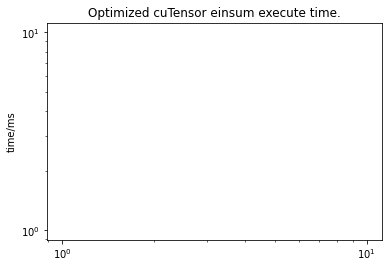

In [3]:
plt.xscale("log")
plt.title("Optimized cuTensor einsum execute time.")
plt.ylabel("time/ms")
plt.yscale("log")
plt.plot(size, time, color="crimson",label="time",)
sec = plt.gca().twinx()
sec.set_yscale("log")
sec.set_yticks([])
sec.plot(size, size, 'b--',label="data size")
plt.legend()
plt.show()


In [34]:
print(size)
print(time)

[1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000, 120000, 130000, 140000, 150000, 160000, 170000, 180000, 190000, 200000, 210000, 220000, 230000, 240000, 250000, 260000, 270000, 280000, 290000, 300000, 310000, 320000, 330000, 340000, 350000, 360000, 370000, 380000, 390000, 400000, 410000, 420000, 430000, 440000, 450000, 460000, 470000, 480000, 490000, 500000, 510000, 520000, 530000, 540000, 550000, 560000, 570000, 580000, 590000, 600000, 610000, 620000, 630000, 640000, 650000, 660000, 670000, 680000, 690000, 700000, 710000, 720000, 730000, 740000, 750000, 760000, 770000, 780000, 790000, 800000, 810000, 820000, 830000, 840000, 850000, 860000, 870000, 880000, 890000, 900000, 910000, 920000, 930000, 940000, 950000, 960000, 970000, 980000, 990000]
[0.30064599999999997, 0.378682, 0.4668405, 0.577122, 0.633401, 1.2653539999999999, 1.3732925, 0.9475279999999999, 1.0285435, 1.1009115, 1.9775775, 3.0798875, 4.05

In [2]:
size=[1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000, 120000, 130000, 140000, 150000, 160000, 170000, 180000, 190000, 200000, 210000, 220000, 230000, 240000, 250000, 260000, 270000, 280000, 290000, 300000, 310000, 320000, 330000, 340000, 350000, 360000, 370000, 380000, 390000, 400000, 410000, 420000, 430000, 440000, 450000, 460000, 470000, 480000, 490000, 500000, 510000, 520000, 530000, 540000, 550000, 560000, 570000, 580000, 590000, 600000, 610000, 620000, 630000, 640000, 650000, 660000, 670000, 680000, 690000, 700000, 710000, 720000, 730000, 740000, 750000, 760000, 770000, 780000, 790000, 800000, 810000, 820000, 830000, 840000, 850000, 860000, 870000, 880000, 890000, 900000, 910000, 920000, 930000, 940000, 950000, 960000, 970000, 980000, 990000]
time=[0.30064599999999997, 0.378682, 0.4668405, 0.577122, 0.633401, 1.2653539999999999, 1.3732925, 0.9475279999999999, 1.0285435, 1.1009115, 1.9775775, 3.0798875, 4.0516985000000005, 5.264778, 6.254784, 7.215557, 8.2143955, 9.1718575, 9.542962, 10.224019, 11.175386, 12.061595, 12.947768, 13.8604385, 14.732555, 15.560421, 16.477663, 17.426307, 18.269692499999998, 19.159055000000002, 21.247177999999998, 20.931699000000002, 21.8890415, 22.738005, 23.682917500000002, 24.5632115, 25.467026, 26.2848265, 27.2523245, 28.168605999999997, 29.047945499999997, 29.8784745, 32.1495515, 31.6613325, 32.5325445, 33.451981, 34.437236999999996, 35.2215195, 36.0744845, 36.970674, 37.929234, 38.759178, 39.682895, 40.5682905, 41.642446500000005, 42.478652999999994, 44.52458, 44.261855, 45.163596999999996, 45.949231499999996, 46.875617000000005, 47.78996, 51.566522500000005, 49.500525499999995, 50.391853, 51.372274000000004, 52.339397500000004, 53.340014, 54.063365000000005, 54.9228645, 55.860785500000006, 56.5958895, 57.698032, 58.544751500000004, 59.305046000000004, 60.218432, 61.197925, 62.050899, 63.0037875, 63.844982, 64.7287685, 65.795204, 66.4694765, 67.315026, 68.385507, 69.38386700000001, 70.1286495, 70.929191, 71.930772, 72.903168, 73.687014, 74.467543, 75.495587, 76.35991200000001, 77.1427845, 78.077473, 79.03022250000001, 79.86287, 80.8038655, 81.7185595, 82.613322, 83.560543, 84.3654565, 85.215452, 86.12943949999999, 89.77832000000001, 90.716679, 91.50139999999999]

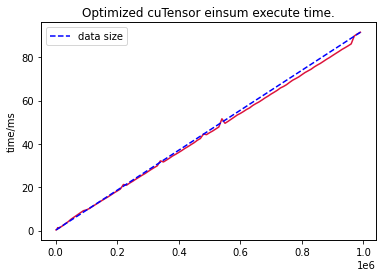

In [4]:
import matplotlib.pyplot as plt

plt.title("Optimized cuTensor einsum execute time.")
plt.ylabel("time/ms")
plt.yscale("linear")
plt.plot(size, time, color="crimson",label="time",)
sec = plt.gca().twinx()
sec.set_yscale("linear")
sec.set_yticks([])
sec.plot(size, size, 'b--',label="data size")
plt.legend()
plt.show()
